In [3]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, Callback

# telegram
import telegram

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import os
import sys
import datetime
import time
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [4]:
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth=True

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.2

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

# change model name to match model you want to predict with

In [40]:
cols = ['Model', 'Set', 'Class','Phone','XPred','YPred','X','Y','rmse','euc','XErr','YErr']
df_ = pd.DataFrame(columns=cols)
df_.to_pickle(str(Path.home())+"/data/model_info_test.pkl")

In [81]:
model_name = "IMU_N6_20190205_115609.h5"
model_path = str(Path.home()) + "/data/models/" + model_name
ID = model_name.split(".")[0]
smartphone = model_name.split("_")[1]
#########################
trainedNormalized = False
plotLegend = True
#########################


directory = str(Path.home()) + "/data/plots/" + model_name.split(".")[0]

if not os.path.exists(directory):
    print("Making directory: " + directory)
    #os.makedirs(directory)

Making directory: /home/beneste/data/plots/IMU_N6_20190205_115609


In [82]:
window_size = 50
batch_size = 500

# set screen resolution and pixel size constant (mm)
if smartphone == "N5X":
    pixels = {"width": 1080, "height": 1920}
    constant_pixels = 0.06
elif smartphone == "S3Mini":
    pixels = {"width": 480, "height": 800}
    constant_pixels = 0.1089
elif smartphone == "S4":
    pixels = {"width": 1080, "height": 1920}
    constant_pixels = 0.0577
elif smartphone == "N6":
    pixels = {"width": 1440, "height": 2560}
    constant_pixels = 0.05109
    
#HDF5_PATH = str(Path.home()) + "/data/hdf-acc/" + smartphone + "-win" + str(window_size) + ".hdf"

In [83]:
###############################################
#Returns screen width, height, pixel size (mm)#
###############################################
def get_screen_size(device):
    return {
        'S3Mini' : np.array([480, 800, 0.1089]),
        'S4' : np.array([1080, 1920, 0.0577]), 
        'N5X': np.array([1080, 1920, 0.06]),
        'N6' : np.array([1440, 2560, 0.05109])
    }.get(device, None)

def normalizeWidth(row):
    smartphone = row.Phone
    return row.XPress / get_screen_size(smartphone)[0]

def normalizeHeight(row):
    smartphone = row.Phone    
    return row.YPress / get_screen_size(smartphone)[1]

########################
#Metrics for evaluation#
########################
def eucInMM(y_true, y_pred):
            return (K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))) * constant_pixels
def euc(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))#
def eucStdMM(y_true, y_pred):
    return K.std(K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1))) * constant_pixels
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

####################################
#Metrics for dataframe calculations#
####################################
def calculate_eucMM(row):
    return math.sqrt((row['XPred'] - row['X'])**2 + (row['YPred'] - row['Y'])**2) * smartphone_values[2]

def calculate_rmseMM(row):
    return math.sqrt(mean_squared_error((row['X'],row['Y']), (row['XPred'],row['YPred']))) * smartphone_values[2]    

def calculate_x_error(row):
    return (row["XPred"] - row["X"]) * smartphone_values[2]

def calculate_y_error(row):
    return (row["YPred"] - row["Y"]) * smartphone_values[2]

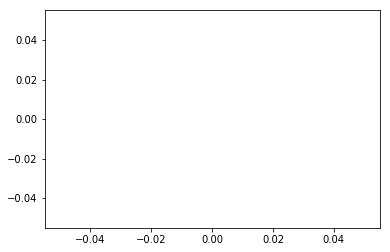

In [84]:
#####################
#Patches for legends#
#####################
colors = ["#fc8d59","#3182bd"]
texts = ["Test","Training"]
colors_predic = ["#91cf60","#fc8d59"]
texts_predic = ["Actual","Prediction"]

patches_origin_double = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]

patches_origin = [plt.plot([], marker="o", ms=10, ls="", mec=None, color=colors[0], 
            label="{:s}".format(texts[0]) )[0]]

patches_predic = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors_predic[i], 
            label="{:s}".format(texts_predic[i]) )[0]  for i in range(len(texts))] 
patches_predic = patches_predic + plt.plot([], marker="_", ms=10, ls="", mec=None, color="#3182bd", label="Relation") 

# Predict on both training and test data

Done!
CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 16.2 s


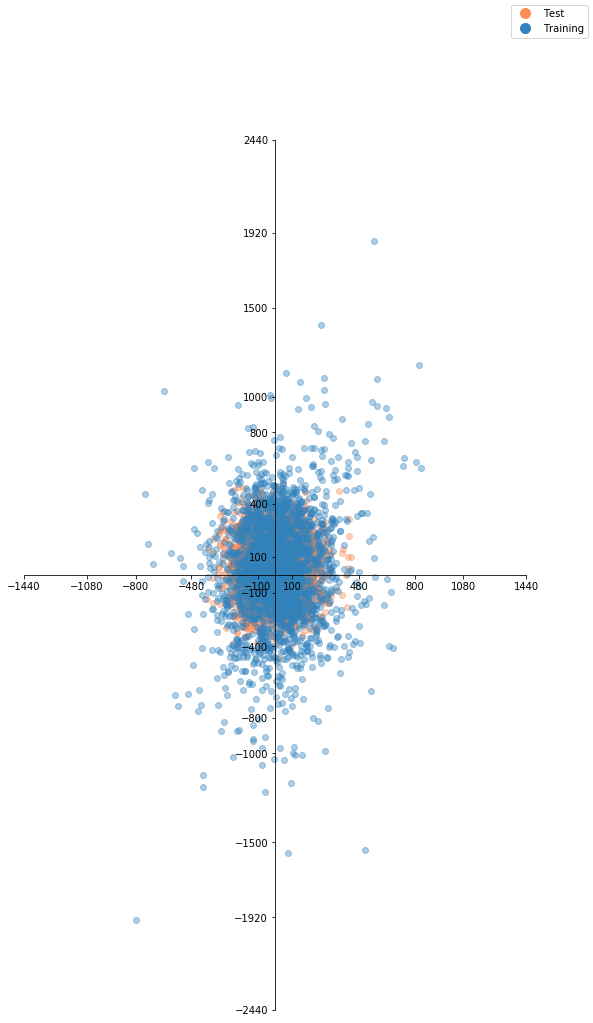

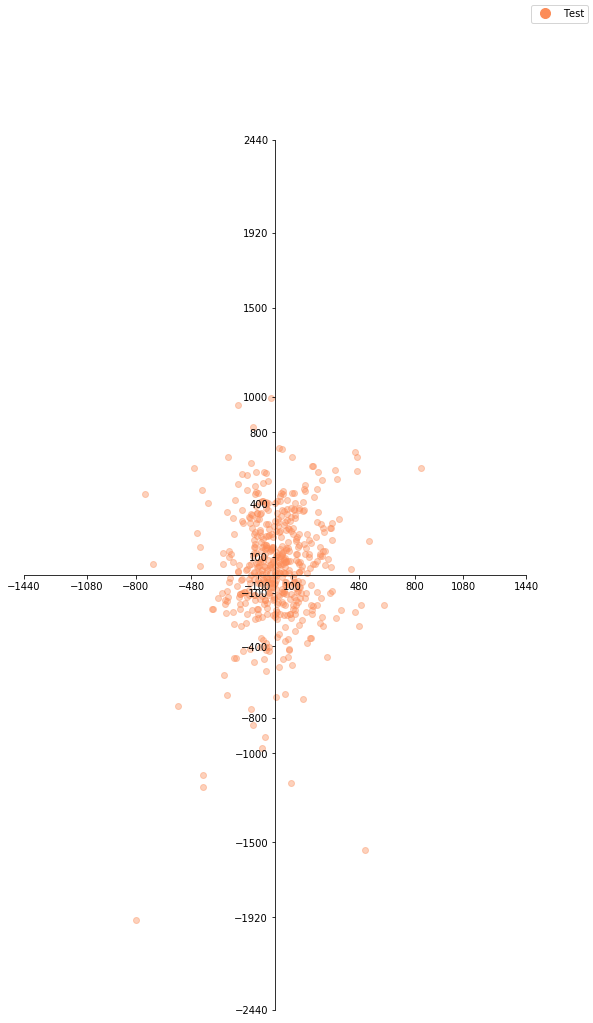

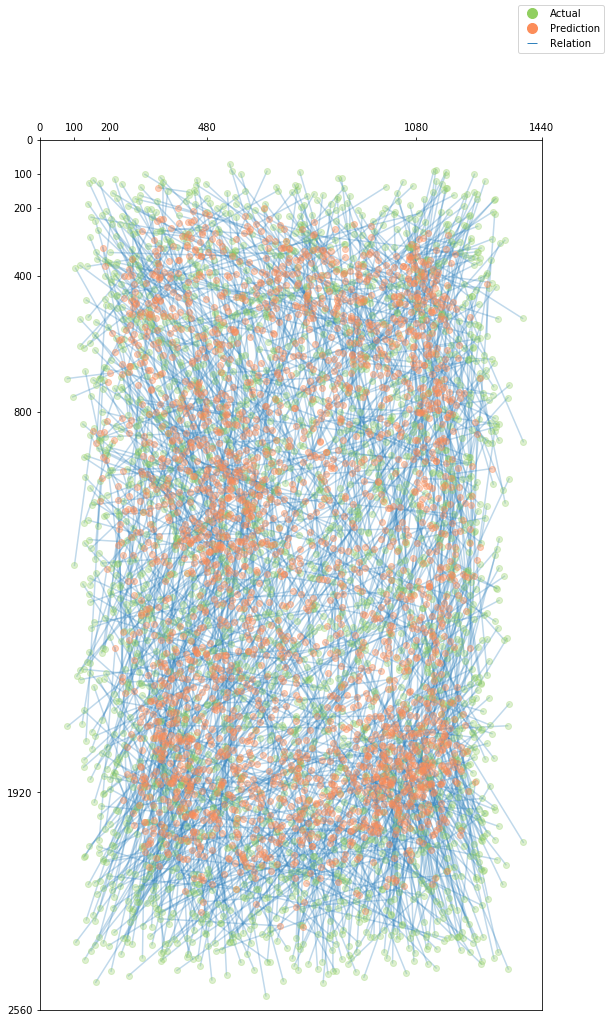

In [85]:
%%time

#############################
#Test figures initialization#
#############################
fig_origin_d, ax_origin_d = plt.subplots(1, figsize=(9,16))
fig_origin_test, ax_origin_test = plt.subplots(1, figsize=(9,16))
fig_pred_test, ax_pred_test = plt.subplots(1, figsize=(9,16))

#########################
#Read complete dataframe and 
df = pd.read_pickle("../../data/step03.pkl")
df = df[(df.Phone == smartphone)]
smartphone_values = get_screen_size(smartphone)

df.Sensor = df.Sensor.apply(lambda x: x[-57:-11])
df.Sensor = df.Sensor.apply(lambda x: x.reshape(-1, 6, 1))
    
np.random.seed(42)
lst = df.PId.unique()
np.random.shuffle(lst)

shape = df.Sensor.iloc[0].shape

if trainedNormalized:
    df.XPress = df.apply(lambda x: normalizeWidth(x), axis=1)
    df.YPress = df.apply(lambda x: normalizeHeight(x), axis=1)

###############################################
#Split dataframe into test and train dataframe#
#Grip train and test x and ys
###############################################
dfTrain = df[df.PId.isin(lst[:14])]
dfTest = df[df.PId.isin(lst[14:])]

train_x = np.concatenate(dfTrain.Sensor.values).reshape(-1, shape[0], shape[1],shape[2])
train_y = dfTrain[['XPress', 'YPress']].values

test_x = np.concatenate(dfTest.Sensor.values).reshape(-1, shape[0], shape[1],shape[2])
test_y = dfTest[['XPress', 'YPress']].values

#############################################################
#Add zeros to dataset to make length dividable by batch size#
#############################################################
test_offset = batch_size - (len(test_x) % batch_size)
test_x_zeros = np.zeros((test_offset, 46, 6, 1))
test_y_zeros = np.zeros((test_offset, 2), dtype = int)
test_y = np.concatenate([test_y, test_y_zeros])
test_x = np.concatenate([test_x, test_x_zeros])

train_offset = batch_size - (len(train_x) % batch_size)
train_x_zeros = np.zeros((train_offset, 46, 6, 1))
train_y_zeros = np.zeros((train_offset, 2), dtype = int)
train_y = np.concatenate([train_y, train_y_zeros])
train_x = np.concatenate([train_x, train_x_zeros])

##################################################################################
#Load the model, predict with it, generate both train and test prediction history#
##################################################################################
tf.get_default_graph()
model = load_model(model_path, custom_objects={'euc':euc, 'rmse':rmse, 'eucInMM': eucInMM, 'eucStdMM': eucStdMM})

optimizer = optimizers.Adam(lr = 0.001, decay = 1e-6)
model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', euc, rmse])

hist_test = model.predict(test_x, batch_size=batch_size, verbose=0, steps=None)
hist_train = model.predict(train_x, batch_size=batch_size, verbose=0, steps=None)

#############################################################################
#Generate DATAFRAMES with all predicitions from training and test validation#
#These are used later for filling the model information dataframe 
#############################################################################
df_train = pd.DataFrame(np.concatenate([hist_train[:-train_offset], train_y[:-train_offset]], axis = 1), 
                        columns = ["XPred","YPred", "X", "Y"])
df_test = pd.DataFrame(np.concatenate([hist_test[:-test_offset], test_y[:-test_offset]], axis = 1), 
                       columns = ["XPred","YPred", "X", "Y"])

####################
#Undo normalization#
####################
if trainedNormalized:
    df_train.XPred = df_train.XPred * smartphone_values[0]
    df_train.YPred = df_train.YPred * smartphone_values[1]
    df_train.X = df_train.X * smartphone_values[0]
    df_train.Y = df_train.Y * smartphone_values[1]

    df_test.XPred = df_test.XPred * smartphone_values[0]
    df_test.YPred = df_test.YPred * smartphone_values[1]
    df_test.X = df_test.X * smartphone_values[0]
    df_test.Y = df_test.Y * smartphone_values[1]

###############################
#Change column type to integer#
###############################
df_train.XPred = df_train.XPred.astype(int) 
df_train.YPred = df_train.YPred.astype(int)
df_train.X = df_train.X.astype(int)
df_train.Y = df_train.Y.astype(int)

df_test.XPred = df_test.XPred.astype(int)
df_test.YPred = df_test.YPred.astype(int)
df_test.X = df_test.X.astype(int)
df_test.Y = df_test.Y.astype(int)

####################
#DOUBLE ORIGIN PLOT#
####################
xticks = [-1440, -1080, -800, -480, -100, 100, 480, 800, 1080, 1440]
yticks = [-2440, -1920, -1500, -1000, -800, -400, -100, 100, 400, 800, 1000, 1500, 1920, 2440]
if "S3Mini" in smartphone:
    ax_origin_d.set_xticks(xticks[3:-3])
    ax_origin_d.set_yticks(yticks[4:-4])
    ax_origin_d.set_xlim(xticks[3], xticks[-4])
    ax_origin_d.set_ylim(yticks[4], yticks[-5])
elif "N6" in smartphone:
    ax_origin_d.set_xticks(xticks[:])
    ax_origin_d.set_yticks(yticks[:])
    ax_origin_d.set_xlim(xticks[0], xticks[-1])
    ax_origin_d.set_ylim(yticks[0], yticks[-1])
else:
    ax_origin_d.set_xticks(xticks[1:-1])
    ax_origin_d.set_yticks(yticks[1:-1])
    ax_origin_d.set_xlim(xticks[1],xticks[-2])
    ax_origin_d.set_ylim(yticks[1],yticks[-2])

ax_origin_d.spines['right'].set_color('none')
ax_origin_d.spines['top'].set_color('none')
ax_origin_d.spines['left'].set_position(('data',0))
ax_origin_d.spines['bottom'].set_position(('data',0))

df_train["x_val"] = df_train.XPred - df_train.X
df_train["y_val"] = df_train.YPred - df_train.Y
ax_origin_d.scatter(df_train.x_val, -df_train.y_val, c = '#fc8d59', alpha = 0.4)

df_test["x_val"] = df_test.XPred - df_test.X
df_test["y_val"] = df_test.YPred - df_test.Y
ax_origin_d.scatter(df_test.x_val, -df_test.y_val, c = '#3182bd', alpha = 0.4)

if (plotLegend):
    fig_origin_d.legend(handles=patches_origin_double, loc='upper right', ncol=1, numpoints=1)

##################
#TEST ORIGIN PLOT#
##################
df_origin = df_test.sample(500)
if "S3Mini" in smartphone:
    ax_origin_test.set_xticks(xticks[3:-3])
    ax_origin_test.set_yticks(yticks[4:-4])
    ax_origin_test.set_xlim(xticks[3], xticks[-4])
    ax_origin_test.set_ylim(yticks[4], yticks[-5])
elif "N6" in smartphone:
    ax_origin_test.set_xticks(xticks[:])
    ax_origin_test.set_yticks(yticks[:])
    ax_origin_test.set_xlim(xticks[0], xticks[-1])
    ax_origin_test.set_ylim(yticks[0], yticks[-1])
else:
    ax_origin_test.set_xticks(xticks[1:-1])
    ax_origin_test.set_yticks(yticks[1:-1])
    ax_origin_test.set_xlim(xticks[1],xticks[-2])
    ax_origin_test.set_ylim(yticks[1],yticks[-2])

ax_origin_test.spines['right'].set_color('none')
ax_origin_test.spines['top'].set_color('none')
ax_origin_test.spines['left'].set_position(('data',0))
ax_origin_test.spines['bottom'].set_position(('data',0))

ax_origin_test.scatter(df_origin.x_val, -df_origin.y_val, c = '#fc8d59', alpha = 0.4)

if (plotLegend):
    fig_origin_test.legend(handles=patches_origin, loc='upper right', ncol=1, numpoints=1)

#######################
#TEST PREDICITION PLOT#
#######################
yticks = [0, 100, 200, 400, 800, 1920, 2560]
xticks = [0, 100, 200, 480, 1080, 1440]

if "S3Mini" in smartphone:
    ax_pred_test.set_xticks(xticks[:5])
    ax_pred_test.set_yticks(yticks[:4])
    ax_pred_test.set_xlim(0, 480)
    ax_pred_test.set_ylim(800, 0)
elif "N6" in smartphone:
    ax_pred_test.set_xticks(xticks)
    ax_pred_test.set_yticks(yticks)
    ax_pred_test.set_xlim(0, 1440)
    ax_pred_test.set_ylim(2560, 0)
else:
    ax_pred_test.set_xticks(xticks[:6])
    ax_pred_test.set_yticks(yticks[:5])
    ax_pred_test.set_xlim(0, 1080)
    ax_pred_test.set_ylim(1920, 0)

ax_pred_test.xaxis.tick_top()

ax_pred_test.scatter(df_test.XPred.values, df_test.YPred.values, c = '#fc8d59', alpha = 0.4, zorder = 1)
ax_pred_test.scatter(df_test.X.values, df_test.Y.values, c = '#91cf60', alpha = 0.3, zorder = 0.5)

for x, y, xpred, ypred in zip(df_test.X.values, df_test.Y.values, df_test.XPred.values, df_test.YPred.values):
    l = mlines.Line2D([x,xpred], [y,ypred], c = '#3182bd', alpha = 0.3,  zorder = -1)
    ax_pred_test.add_line(l)

if (plotLegend):
    fig_pred_test.legend(handles=patches_predic, loc='upper right', ncol=1, numpoints=1)

################################################
#Append new data to model information dataframe#
################################################

df_info = pd.read_pickle(str(Path.home())+"/data/model_info_test.pkl")
cols = df_info.columns.tolist()

df_test["Model"] = ID
df_test["Set"] = "test"
df_test["Class"] = "single"
df_test["Phone"] = smartphone
df_test['rmse'] = df_test.apply(calculate_rmseMM, axis = 1) 
df_test['euc'] = df_test.apply(calculate_eucMM, axis = 1)
df_test['XErr'] = df_test.apply(calculate_x_error, axis = 1)
df_test['YErr'] = df_test.apply(calculate_y_error, axis = 1)
df_test = df_test[cols]

df_train["Model"] = ID
df_train["Set"] = "train"
df_train["Class"] = "single"
df_train["Phone"] = smartphone
df_train['rmse'] = df_train.apply(calculate_rmseMM, axis = 1) 
df_train['euc'] = df_train.apply(calculate_eucMM, axis = 1)
df_train['XErr'] = df_train.apply(calculate_x_error, axis = 1)
df_train['YErr'] = df_train.apply(calculate_y_error, axis = 1)
df_train = df_train[cols]

df_info = pd.concat([df_info, df_test, df_train], ignore_index = True)
df_info.to_pickle(str(Path.home())+"/data/model_info_test.pkl")
print("Done!")

# Figure export

path_current = export_path + "/" + smartphone + "_"
print("Exporting figures for: " + smartphone)
fig_origin_d[i].savefig(path_current + "origin-d_" + ID + ".pdf", bbox_inches = "tight")
fig_origin_test[i].savefig(path_current + "origin_" + ID + ".pdf", bbox_inches = "tight")
fig_pred_test[i].savefig(path_current + "pred_" + ID + ".pdf", bbox_inches = "tight")

In [86]:
from sklearn.covariance import EllipticEnvelope

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


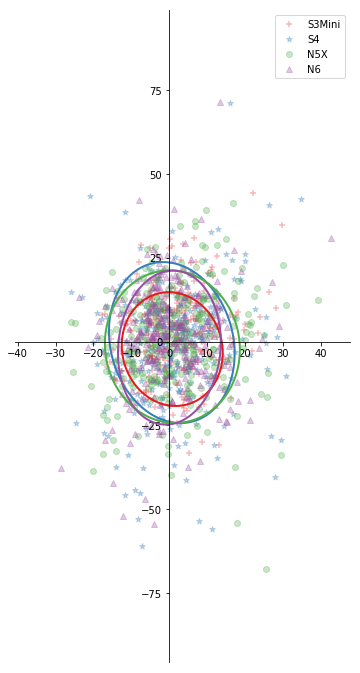

In [88]:
df_info = df_info[df_info.Set =="test"]
df_info["x_val"] = df_info.XPred - df_info.X
df_info["y_val"] = df_info.YPred - df_info.Y
df_info["x_val_mm"] = -1
df_info["y_val_mm"] = -1
smartphones = ["S3Mini","S4","N5X", "N6"]
for p in smartphones:
    df_info.loc[df_info.Phone == p, "x_val_mm"] = df_info.loc[df_info.Phone == p].x_val * get_screen_size(p)[2]
    df_info.loc[df_info.Phone == p, "y_val_mm"] = df_info.loc[df_info.Phone == p].y_val * get_screen_size(p)[2]
df_x = df_info[df_info.Set == "test"]

fig1, ax1 = plt.subplots(1, figsize=(6,12))
marker = ["+","*","o","^"]
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.spines['left'].set_position(('data',0))
ax1.spines['bottom'].set_position(('data',0))
#ax1.set_xticks(xticks[:])
#ax1.set_yticks(yticks[:])

for i, phone in enumerate(smartphones):
    smartphone_values = get_screen_size(phone)
    df_tmp = df_x[df_x.Phone == phone].sample(300)
    plt.scatter(df_tmp.x_val_mm, -df_tmp.y_val_mm, alpha = 0.3, marker = marker[i],c = colors[i], label = phone)
#     ell_width = abs(df_tmp.XErr.mean())+(abs(df_tmp.XErr.std())*2)
#     ell_heigth = abs(df_tmp.YErr.mean())+(abs(df_tmp.YErr.std())*2)
#     ell = mpatches.Ellipse((0,0), ell_width, ell_heigth, fill = False)#, color = colors[i])
#     ax1.add_patch(ell)
    X2 = df_x[df_x.Phone == phone][['x_val_mm', 'y_val_mm']].values

    clf = EllipticEnvelope(contamination=0.261)

    xx2, yy2 = np.meshgrid(np.linspace(X2[:, 0].min(), X2[:, 0].max(), 500), np.linspace(X2[:, 1].min(), X2[:, 1].max(), 500))
    clf.fit(X2)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    plt.contour(xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i])


plt.legend()
plt.savefig("../../data/plots/ellipses_single.pdf", bbox_inches = "tight")